참고 : https://zero-ai.tistory.com/62

In [1]:
import torch

print(f"CUDA 사용 가능 여부: {torch.cuda.is_available()}")
print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
print(f"CUDA 버전: {torch.version.cuda}")
print(f"PyTorch 버전: {torch.version}")
print(f"bf16 지원 여부: {torch.cuda.is_bf16_supported()}")
print(f"현재 GPU : {torch.cuda.current_device()}")

CUDA 사용 가능 여부: True
GPU 이름: NVIDIA GB10
CUDA 버전: 13.0
PyTorch 버전: <module 'torch.version' from '/home/vsc/LLM_TUNE/.venv_vLLM/lib/python3.12/site-packages/torch/version.py'>
bf16 지원 여부: True
현재 GPU : 0


/home/vsc/LLM_TUNE/.venv_vLLM/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


In [2]:
import torch

def check_vram_torch():
    # 1. 현재 텐서들이 실제로 점유하고 있는 메모리
    allocated = torch.cuda.memory_allocated() / (1024**3)
    # 2. PyTorch가 OS로부터 할당받아 캐싱하고 있는 전체 메모리
    reserved = torch.cuda.memory_reserved() / (1024**3)
    # 3. 해당 GPU의 전체 용량
    total = torch.cuda.get_device_properties(0).total_memory / (1024**3)

    print(f"--- GPU Memory Status ---")
    print(f"Allocated: {allocated:.2f} GB")
    print(f"Reserved:  {reserved:.2f} GB")
    print(f"Total:     {total:.2f} GB")
    print(f"Free (in Reserved): {reserved - allocated:.2f} GB")
    print(f"--------------------------")

check_vram_torch()

--- GPU Memory Status ---
Allocated: 0.00 GB
Reserved:  0.00 GB
Total:     119.70 GB
Free (in Reserved): 0.00 GB
--------------------------


In [1]:
from datasets import Dataset
import pandas as pd
import glob

file_path = glob.glob("./data/*.xlsx")
df = pd.read_excel(file_path[0])
dataset = Dataset.from_pandas(df)

print(dataset)
print(dataset[0])

Dataset({
    features: ['FAQ', 'TITLE', 'DES'],
    num_rows: 110
})
{'FAQ': 1, 'TITLE': '회원증을 대리발급 할 수 있나요?', 'DES': '회원증 대리발급은 만14세 미만 아동, 만65세 이상 어르신, 장애인, 임산부만 가능하며 아래 구비서류를 지참하여 대리인이 방문 시 대리발급이 가능합니다.\n\n· 대상 : 만14세 미만 아동, 만65세 이상 어르신, 장애인, 임산부\n· 구비서류\n\xa0 - 공통 : ①위임자 신분증, ②피위임자(대리인) 신분증\n\xa0 - 장애인 : 장애인 복지카드 또는 장애인 증명서\n\xa0 - 임신부 : 산모수첩 / 산모 : 주민등록등본(출산 후 12개월까지)\n· 방법 : 홈페이지 회원가입 후 위 항목의 해당하는 구비서류를 지참하여 피위임자(대리인)이 도서관 방문'}


In [2]:
# 데이터 증강을 위해 로컬 EXAONE-3.5-7.8B-Instruct 모델 사용
# Instruct 모델 : 명령 / 지시를 내리는 모델
# 일반 LLM 모델 : 텍스트를 자연스럽게 이어가는 데 초점을 둔 모델

In [3]:
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig, 
    TrainingArguments,
)
from datasets import Dataset
import os, torch, json, wandb, subprocess
from sklearn.model_selection import train_test_split
import torch.nn as nn
from vllm import LLM, SamplingParams

In [4]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="EMPTY"
)

MODEL_NAME = "/home/vsc/LLM/model/Exaone-3.5-32B-Instruct"

In [5]:
# vLLM의 경우 pipeline 방식에 비해 추론 속도가 빠르며, 메모리 안정성이 더 높음 + continuous batching으로 한 번에 여러 응답을 받을 수 있 음

In [8]:
def generate_augmented_data(faq_content):
    system_message = (
        "당신은 도서관 FAQ 데이터를 바탕으로 자연스러운 대화형 학습 데이터를 생성하는 전문가입니다.\n"
        "제공된 정보를 분석하여 다음 4가지 유형의 데이터를 생성하세요. 각 유형별로 최소 3개씩, 총 12개의 예시를 만드세요.\n\n"
        "이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
        
        "### [답변 가이드라인]\n"
        "1. **label: 'yes' (긍정 확인)**\n"
        "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
        "   - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n"
        "   - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n"
        "2. **label: 'no' (부정/제한)**\n"
        "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
        "   - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n"
        "   - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n"
        "3. **label: 'info' (단순 정보 제공)**\n"
        "   - 질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n"
        "   - 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n"
        "   - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n"
        "4. **label: 'false' (판단 불가)**\n"
        "   - 문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n"
        "   - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
        
        "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
        "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
        "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
    [도서관 FAQ 정보]
    {faq_content}
    
    위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
    
    [출력 예시]:
    [
      {{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}},
      {{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}},
      {{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}},
      {{"question": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}}
    ]
    """
    
    chat_completion = client.chat.completions.create(
        model=MODEL_NAME,
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_content},
        ],
        temperature=0.7,   # 창의성 조절 (0.0 ~ 2.0)
        max_tokens=2048,   # 생성할 최대 토큰 수
        top_p=0.9,         # 답변의 다양성 조절
    )

    response = chat_completion.choices[0].message.content
    
    return response

In [9]:
import json
import re
import pandas as pd

def parse_generated_json(response_text):
    try:
        # 1. 마크다운 코드 블록 제거 (```json ... ``` 사이의 내용만 추출)
        json_pattern = re.compile(r"```json\s*(.*?)\s*```", re.DOTALL)
        match = json_pattern.search(response_text)
        
        if match:
            json_str = match.group(1)
        else:
            json_str = response_text.strip()
            
        # 2. JSON 문자열을 파이썬 리스트로 변환
        data_list = json.loads(json_str)
        return data_list
    except Exception as e:
        print(f"파싱 에러 발생: {e}")
        return []

In [13]:
from tqdm import tqdm

output_file = "augmented_library_faq_quant_EXAONE_32B_vLLM.jsonl"

with open(output_file, "a", encoding="utf-8") as f:
    for i, row in enumerate(tqdm(dataset.select(range(108, len(dataset))), desc="Data Augmentation")):
        # 1. 모델로부터 텍스트 생성
        raw_output = generate_augmented_data(row["DES"])
        
        # 2. 파싱하여 리스트로 변환
        parsed_list = parse_generated_json(raw_output)
        
        for item in parsed_list:
            item['faq'] = row['FAQ'] 
            item['title'] = row['TITLE'] 
            item['DES'] = row['DES']
            
            f.write(json.dumps(item, ensure_ascii=False) + "\n")
            
print(f"✅ 총 {len(df)}개의 학습 데이터 생성 완료!")

Data Augmentation: 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [02:15<00:00, 67.78s/it]

✅ 총 110개의 학습 데이터 생성 완료!


In [5]:
# wanDB & weave + W&B artifact 셋업

In [9]:
import json
import asyncio, aiofiles
import wandb
from tqdm.asyncio import tqdm as async_tqdm
from openai import AsyncOpenAI
import weave

PROJECT_NAME="library-faq-augmentation"

config = {
    "model": "Exaone-3.5-32B-Instruct",
    "quantization": "bitsandbytes",
    "engine": "vLLM-v1",
    "temperature": 0.7,
    "max_model_len": 16384,
}

wandb.init(project=PROJECT_NAME, name="EXAONE-32B-vLLM-Run")
weave.init(PROJECT_NAME)
sample_table = wandb.Table(columns=["row_id", "question", "answer", "label"])
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="EMPTY")

wandb: Initializing weave.


Output()

weave: Logged in as Weights & Biases user: jungseonglian.
weave: View Weave data at https://wandb.ai/uailab-unist_/library-faq-augmentation/weave
[2026-02-08 18:15:49] INFO init_message.py:174: Logged in as Weights & Biases user: jungseonglian.
View Weave data at https://wandb.ai/uailab-unist_/library-faq-augmentation/weave


In [10]:
# async 셋업

In [13]:
@weave.op()
async def generate_augmented_data_async(faq_content, row_id) :
    system_message = (
    "당신은 도서관 FAQ 데이터를 바탕으로 자연스러운 대화형 학습 데이터를 생성하는 전문가입니다.\n"
    "제공된 정보를 분석하여 다음 4가지 유형의 데이터를 생성하세요. 각 유형별로 최소 3개씩, 총 12개의 예시를 만드세요.\n\n"
    "이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
    
    "### [답변 가이드라인]\n"
    "1. **label: 'yes' (긍정 확인)**\n"
    "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
    "   - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n"
    "   - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n"
    "2. **label: 'no' (부정/제한)**\n"
    "   - 질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n"
    "   - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n"
    "   - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n"
    "3. **label: 'info' (단순 정보 제공)**\n"
    "   - 질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n"
    "   - 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n"
    "   - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n"
    "4. **label: 'false' (판단 불가)**\n"
    "   - 문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n"
    "   - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
    
    "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
    "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
    "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
        [도서관 FAQ 정보]
        {faq_content}
        
        위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
        
        [출력 예시]:
        [
          {{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}},
          {{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}},
          {{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}},
          {{"question": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}}
        ]
    """
    
    try :
        chat_completion = await client.chat.completions.create(
            model=MODEL_NAME,
            messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_content},
            ],
            temperature=0.7,   # 창의성 조절 (0.0 ~ 2.0)
            max_tokens=2048,   # 생성할 최대 토큰 수
            top_p=0.9,         # 답변의 다양성 조절
        )

        raw_output = chat_completion.choices[0].message.content

        if "```json" in raw_output:
            raw_output = raw_output.split("```json")[1].split("```")[0].strip()

        parsed_list = json.loads(raw_output)

        if row_id < 5:
            for item in parsed_list[:2]:
                sample_table.add_data(row_id, item.get("question"), item.get("answer"), item.get("label"))
        
        return parsed_list

    except Exception as e :
        print(f"Error at {row_id} : {e}")
        return []
    
async def process_dataset(dataset) :
    output_file = "async_library_faq_quant_EXAONE_32B_vLLM_async.jsonl"
    async with aiofiles.open(output_file, "w", encoding="utf-8") as f:
        semaphore = asyncio.Semaphore(2)
        lock = asyncio.Lock()

        async def semaphore_task(row, idx) :
            async with semaphore :
                results = await generate_augmented_data_async(row["DES"], idx)
                
                if results:  # 결과가 있을 때만 쓰기
                    async with lock:
                        for item in results:
                            item.update({
                                'faq': row['FAQ'], 
                                'title': row['TITLE'], 
                                'DES': row['DES']
                            })
                            await f.write(json.dumps(item, ensure_ascii=False) + "\n")
                
                return len(results)

        tasks = [semaphore_task(row, i) for i, row in enumerate(dataset)]

        total_created = 0
        for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks), desc="데이터 생성"):
            total_created += await coro

    wandb.log({"augmented_samples": sample_table})
    wandb.finish()
    print(f"✅ 생성 완료! 총 {total_created}개의 데이터가 저장되었습니다.")

    return output_file

In [7]:
outputfile_name = await process_dataset(dataset)
artifact = wandb.Artifact(f"{outputfile_name}_v0", type='dataset')
artifact.add_file(output_filename)
wandb.log_artifact(artifact)

NameError: name 'process_dataset' is not defined

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

data = []
with open("augmented_library_faq.jsonl", "r", encoding="utf-8") as f :
    for line in f :
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [2]:
# 생성된 데이터 확인 (결측치 확인 및 데이터 보강을 위함)

print(df["label"].value_counts())
print("-----")
print(df.isnull().sum())
print("-----")
print(df.info())

label
info     593
yes      533
false    435
no       388
Name: count, dtype: int64
-----
question        2
answer         16
label           1
faq             0
title         678
답변           1943
augmented    1272
dtype: int64
-----
<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1934 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   답변         7 non-null      str   
 6   augmented  678 non-null    object
dtypes: object(2), str(5)
memory usage: 701.6+ KB
None


In [3]:
import pandas as pd

if "답변" in df.columns :
    df["answer"] = df["answer"].fillna(df["답변"])
    df = df.drop(columns=["답변"])

print(df.info())
print(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1941 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   augmented  678 non-null    object
dtypes: object(2), str(4)
memory usage: 686.1+ KB
None
question        2
answer          9
label           1
faq             0
title         678
augmented    1272
dtype: int64


In [4]:
df = df.dropna(subset=["question", "answer", "label"])
df = df.reset_index(drop=True) # drop된 행의 인덱스를 다시 매기기

print(df.info()) 

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1939 non-null   str   
 1   answer     1939 non-null   str   
 2   label      1939 non-null   str   
 3   faq        1939 non-null   object
 4   title      1262 non-null   str   
 5   augmented  677 non-null    object
dtypes: object(2), str(4)
memory usage: 683.9+ KB
None


--- [1. Label Distribution] ---
label
info     586
yes      533
false    433
no       387
Name: count, dtype: int64


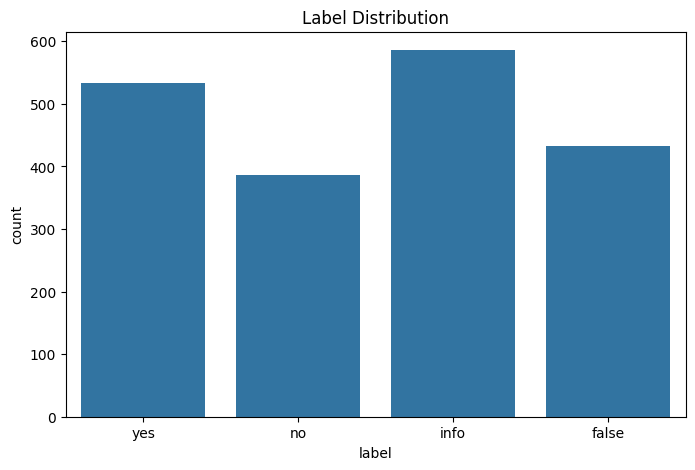

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# 2. 라벨 분포 확인 (균형성)
print("--- [1. Label Distribution] ---")
print(df['label'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=['yes', 'no', 'info', 'false'])
plt.title("Label Distribution")
plt.savefig("label_distribution.png")

In [6]:
pivot = df.groupby(["title", "label"]).size().unstack(fill_value=0)
print(pivot)
need_aug_idx = pivot[(pivot["yes"]<=1) | (pivot["no"]<=1) | (pivot["false"] <=1)]

print(len(pivot))
print(len(need_aug_idx))

label                                               false  info  no  yes
title                                                                   
E-BOOK 리더기(크레마)에서 YES24 서비스가 안되는 경우                     1     7   4    0
가족회원이 무엇인가요?                                            2     3   3    4
가좌도서관 위치 및 전화번호가 어떻게 되나요?                               2     5   0    5
가좌도서관 이용시간이 어떻게 되나요?                                    1     3   3    3
가좌도서관 휴관일은 언제인가요?                                       2     7   2    1
...                                                   ...   ...  ..  ...
화정어린이도서관 이용시간이 어떻게 되나요?                                 1     3   3    5
화정어린이도서관 휴관일은 언제인가요?                                    1     6   2    3
회원증은 도서관마다 각각 만들어야 하나요? 또, 회원증을 분실한 경우에는 어떻게 해야...      3     4   1    4
회원증을 대리발급 할 수 있나요?                                      1     5   4    3
희망도서 신청은 어떻게 하며, 도서구입은 얼마나 자주하나요?                       1     3   4    4

[106 rows x 4 columns]
106
88


In [11]:
def generate_targeted_data(faq_content, target_labels):
    # 필요한 라벨에 대한 가이드라인 / 예시만 프롬프트로 넣어서, 다른 예시가 생성되지 않도록 하기
    all_guidelines = {
        "yes" : "질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n - 문구: '네, 가능합니다! 도서관 규정에 따르면...'\n - 활용: 질문의 조건이 FAQ와 일치할 때 사용.\n",
        "no" : "질문이 '~할 수 있나요?', '~인가요?'처럼 '가부'를 물을 때만 사용하세요.\n - 문구: '죄송하지만 어렵습니다. 그 이유는...'\n - 활용: 질문의 조건이 FAQ 규정에 어긋날 때 사용. '사실과 다르다'는 표현 대신 '규정상 어렵다'를 사용하세요.\n",
        "info" : "질문이 '~은 무엇인가요?', '~은 어떻게 하나요?', '~은 언제인가요?'처럼 절차/시간/방법을 물을 때 사용하세요.\n 문구: '문의하신 내용에 대해 안내해 드리겠습니다. 관련 서류는...'\n - 활용: 네/아니오 판단이 아닌 정보 질문에 사용.\n",
        "false" : "문구: '죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.'\n - 활용: FAQ에 없는 내용이거나 질문이 모호할 때 사용.\n\n"
    }
    selected_guidelines = "\n".join([all_guidelines[l] for l in target_labels if l in all_guidelines])

    all_examples = {
        "yes": '{"question": "임산부인데 남편이 대신 발급받을 수 있나요?", "answer": "네, 가능합니다! 도서관 규정에 따르면 임산부의 경우 대리 발급 대상에 포함됩니다.", "label": "yes"}',
        "no": '{"question": "성인 직장인인데 친구가 대신 가도 되나요?", "answer": "죄송하지만, 해당 조건으로는 대리 발급이 어렵습니다. 대리 발급은 아동, 어르신, 장애인, 임산부로 대상이 제한되어 있기 때문입니다.", "label": "no"}',
        "info": '{"question": "장애인 대리 발급 시 어떤 서류가 필요한가요?", "answer": "문의하신 내용에 대해 안내해 드리겠습니다. 장애인 복지카드 또는 장애인 증명서를 지참하시면 됩니다.", "label": "info"}',
        "false": '{"question": "도서관 근처에 맛있는 식당이 어디인가요?", "answer": "죄송합니다. 현재 제공된 정보만으로는 해당 내용을 확인하기 어렵습니다.", "label": "false"}'
    }   

    target_str = ", ".join(target_labels)
    selected_examples = ",\n      ".join([all_examples[l] for l in target_labels if l in all_examples])
    system_message = (
        f"당신은 도서관 FAQ 데이터를 바탕으로 부족한 유형의 학습 데이터를 보충하는 전문가입니다.\n"
        f"제공된 정보를 분석하여 반드시 다음 라벨에 해당하는 데이터만 생성하세요 : **[{target_str}]**\n\n"
        f"이때 판단이 쉬운 예시와 보통, 어려운 예시 총 3가지 상황을 가정하세요."
        f"각 라벨마다 최소 2~3개의 답변을 생성하세요"
        
        f"### [답변 가이드라인]\n{selected_guidelines}\n\n"
        "모든 답변은 실제 도서관 사서가 방문객에게 설명하듯 친절하고 자연스러운 문장으로 작성하세요."
        f"**[{target_str}]**에 해당하지 않는 라벨은 절대로 생성하지 마세요"
        "판단 불가의 경우 문구 외에 다른 문장은 생성하지 마세요."
        "JSON 답변 외에 다른 문장은 일체 생성하지 마세요."
    )

    # 사용자가 정의한 user_content
    user_content = f"""
    [도서관 FAQ 정보]
    {faq_content}
    
    위 정보를 바탕으로 질문과 답변이 논리적으로 완벽하게 이어지는 JSON 데이터를 생성하세요.
    
    [출력 예시]:
    {selected_examples}
    """
    
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_content},
    ]

    print(messages)

    prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
    )

    outputs = pipe(
        prompt, 
        max_new_tokens=2048, 
        do_sample=True, 
        temperature=0.7,
        truncation=True,
        eos_token_id=tokenizer.eos_token_id
    )

    # 생성된 텍스트 추출 (결과값만 깔끔하게 가져오기 위해 prompt 이후 내용만 슬라이싱)
    full_text = outputs[0]["generated_text"]
    response = full_text.split("[|assistant|]")[-1].strip()
    
    return response

In [12]:
# 각 행마다 부족한 데이터 유형을 확인하여 데이터 증강

from tqdm import tqdm

output_file = "augmented_library_faq.jsonl"
target_titles = need_aug_idx.index.tolist()

with open(output_file, "a", encoding="utf-8") as f :
    pbar = tqdm(target_titles, desc="타겟 라벨 보충")
    
    for title in pbar :
        current = pivot.loc[title]
        missing_labels_list = [label for label in ["yes", "no", "false"] if current[label] <= 3]
    
        if not missing_labels_list :
            continue
    
        missing_labels = ", ".join(missing_labels_list)
        pbar.set_postfix(FAQ=title[:10] + "..", Labels=missing_labels)
        
        faq_data = [x for x in dataset if x["TITLE"] == title][0]
        faq_content = faq_data["DES"]

        try :
            raw_output = generate_targeted_data(faq_content, missing_labels_list)
            print(raw_output)
            parsed_list = parse_generated_json(raw_output)

            for item in parsed_list :
                item["title"] = title
                item["faq"] = 
                item["augmented"] = True

                f.write(json.dumps(item, ensure_ascii=False) + "\n")
        except Exception as e:
            tqdm.write(f"\n[에러 발생] {title}: {e}")
            continue

SyntaxError: invalid syntax (868370360.py, line 31)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

data = []
with open("augmented_library_faq.jsonl", "r", encoding="utf-8") as f :
    for line in f :
        data.append(json.loads(line))

df = pd.DataFrame(data)

In [8]:
# 생성된 데이터 확인 (결측치 확인 및 데이터 보강을 위함)

print(df["label"].value_counts())
print("-----")
print(df.isnull().sum())
print("-----")
print(df.info())

label
info     593
yes      533
false    435
no       388
Name: count, dtype: int64
-----
question        2
answer         16
label           1
faq             0
title         678
답변           1943
augmented    1272
dtype: int64
-----
<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1934 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   답변         7 non-null      str   
 6   augmented  678 non-null    object
dtypes: object(2), str(5)
memory usage: 701.6+ KB
None


In [9]:
import pandas as pd

if "답변" in df.columns :
    df["answer"] = df["answer"].fillna(df["답변"])
    df = df.drop(columns=["답변"])

print(df.info())
print(df.isnull().sum())

<class 'pandas.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1948 non-null   str   
 1   answer     1941 non-null   str   
 2   label      1949 non-null   str   
 3   faq        1950 non-null   object
 4   title      1272 non-null   str   
 5   augmented  678 non-null    object
dtypes: object(2), str(4)
memory usage: 686.1+ KB
None
question        2
answer          9
label           1
faq             0
title         678
augmented    1272
dtype: int64


In [10]:
df = df.dropna(subset=["question", "answer", "label"])
df = df.reset_index(drop=True) # drop된 행의 인덱스를 다시 매기기

print(df.info()) 

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question   1939 non-null   str   
 1   answer     1939 non-null   str   
 2   label      1939 non-null   str   
 3   faq        1939 non-null   object
 4   title      1262 non-null   str   
 5   augmented  677 non-null    object
dtypes: object(2), str(4)
memory usage: 683.9+ KB
None


--- [1. Label Distribution] ---
label
info     586
yes      533
false    433
no       387
Name: count, dtype: int64


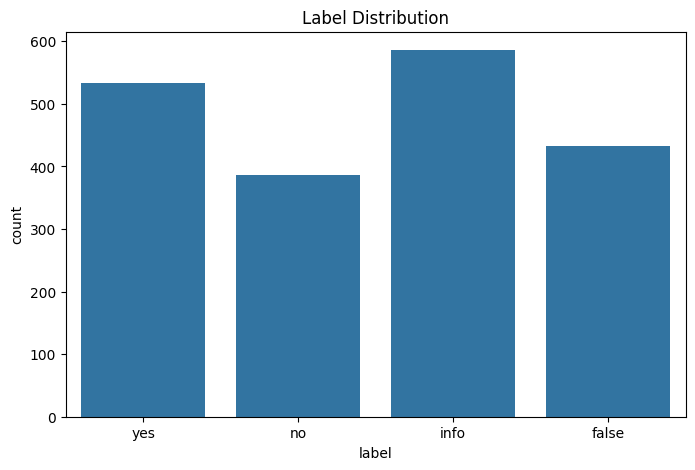

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# 2. 라벨 분포 확인 (균형성)
print("--- [1. Label Distribution] ---")
print(df['label'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', order=['yes', 'no', 'info', 'false'])
plt.title("Label Distribution")
plt.savefig("label_distribution.png")

In [14]:
import pandas as pd

id_to_des = {x['FAQ']: x['DES'] for x in dataset}
title_to_des = {x['TITLE']: x['DES'] for x in dataset}

def recovery_des(faq_val):
    # 만약 숫자라면 (원본 FAQ 번호인 경우)
    if isinstance(faq_val, (int, float)) or (str(faq_val).isdigit()):
        return id_to_des.get(int(faq_val), "본문 없음")
    # 만약 문자열이라면 (실수로 들어간 TITLE인 경우)
    else:
        return title_to_des.get(faq_val, "본문 없음")

df['description'] = df['faq'].apply(recovery_des) # 데이터프레임에 함수 적용

KeyError: 'faq'

In [17]:
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 1939 entries, 0 to 1938
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     1939 non-null   str   
 1   answer       1939 non-null   str   
 2   label        1939 non-null   str   
 3   faq          1939 non-null   object
 4   title        1262 non-null   str   
 5   augmented    677 non-null    object
 6   description  1939 non-null   str   
dtypes: object(2), str(5)
memory usage: 1.3+ MB
None


In [7]:
# 결측치 처리 및 데이터 증강 이후 파인튜닝

In [18]:
# 3. 학습 시킬 모델 불러오기

from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig, 
    TrainingArguments,
)
from datasets import Dataset
import os, torch, json, wandb, subprocess
from sklearn.model_selection import train_test_split
import torch.nn as nn
from peft import (
    get_peft_model,
    LoraConfig, 
    TaskType,
    prepare_model_for_kbit_training
)

In [19]:
# 모델 및 토크나이저 불러오기

model_id = "/home/vsc/LLM/model/EXAONE-3.5-7.8B-Instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

print(model)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

ExaoneForCausalLM(
  (transformer): ExaoneModel(
    (wte): Embedding(102400, 4096, padding_idx=0)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x ExaoneBlock(
        (ln_1): ExaoneRMSNorm()
        (attn): ExaoneAttention(
          (attention): ExaoneSdpaAttention(
            (rotary): ExaoneRotaryEmbedding()
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
          )
        )
        (ln_2): ExaoneRMSNorm()
        (mlp): ExaoneGatedMLP(
          (c_fc_0): Linear(in_features=4096, out_features=14336, bias=False)
          (c_fc_1): Linear(in_features=4096, out_features=14336, bias=False)
          (c_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act): SiLU

In [20]:
# LoRA를 붙힐 레이어의 명칭을 찾아주는 코드

def find_all_linear_names(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
 
modules = find_all_linear_names(model)
print(modules)

['k_proj', 'v_proj', 'q_proj', 'c_proj', 'out_proj', 'c_fc_0', 'c_fc_1']


In [21]:
# 어떤 부분을 학습하냐에 따라서도 결과 값이 달라짐
modules = ["q_proj", "k_proj", "v_proj", "out_proj"]

# 변경 가능한 파라미터들
peft_config = LoraConfig(
    task_type="CAUSAL_LM", #CAUSAL_LM, FEATURE_EXTRACTION, QUESTION_ANS, SEQ_2_SEQ_LM, SEQ_CLS, TOKEN_CLS.
    inference_mode=False, # 학습 중에는 False로 두어야 가중치 업데이트 가능
    r=32, # r은 보통 2의 배수로 두는데, r이 클수록 학습 가능한 파라미터의 수가 더 많아짐
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=modules
)

print(peft_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=32, target_modules={'k_proj', 'out_proj', 'v_proj', 'q_proj'}, lora_alpha=16, lora_dropout=0.05, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))


In [22]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 27,262,976 || all params: 7,845,711,872 || trainable%: 0.3475


In [16]:
df['faq'] = df['faq'].astype(str)
hf_dataset = Dataset.from_pandas(df[["question", "answer","description"]])
seed = 42

ds_split = hf_dataset.train_test_split(test_size=0.2, seed=seed)
train_val_split = ds_split["train"].train_test_split(test_size = 0.3, seed=seed)

from datasets import DatasetDict

final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': ds_split['test']
})

print(final_dataset)
print(final_dataset['train'][0])

KeyError: 'faq'

In [31]:
train_dataset, val_dataset, test_dataset = final_dataset['train'], final_dataset['val'], final_dataset['test']
print(train_dataset)

Dataset({
    features: ['question', 'answer', 'description'],
    num_rows: 1085
})


In [35]:
def generate_prompts(examples):
    prompt_list = []
    system_message = (
        "당신은 도서관 운영에 대한 전문적인 지식을 가진 인공지능 사서입니다."
        "제공된 [도서관 정보]를 바탕으로 사용자의 질문에 정확하고 친절하게 답하십시오. "
        "정보에 없는 내용은 함부로 추측하지 말고 정중히 확인이 어렵다고 답하세요."
    )
    
    for i in range(len(examples['question'])):
        question = examples["question"][i]
        answer = examples["answer"][i]
        context = examples["description"][i]

        user_content = (
            f"### [도서관 정보]\n{context}\n\n"
            f"### [질문]\n{question}\n\n"
            f"### [지시 사항]\n"
            f"1. 친절한 말투로 규정에 근거하여 답변할 것.\n"
            f"2. 3문단 이내로 답변할 것.\n"
            f"3. 답변 끝에 지시 사항을 반복하지 말 것."
        )

        # 채팅 템플릿 구성
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_content},
            {"role": "assistant", "content": answer}
        ]

        full_prompt = tokenizer.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=False
        )
        
        prompt_list.append(full_prompt)
    
    return prompt_list

In [36]:
# max_length 결정 (GPU Util을 최적화 하기 위함)

def generate_prompts_test(example) :
    system_message = (
        "당신은 도서관 운영에 대한 전문적인 지식을 가진 인공지능 사서입니다."
        "제공된 [도서관 정보]를 바탕으로 사용자의 질문에 정확하고 친절하게 답하십시오. "
        "정보에 없는 내용은 함부로 추측하지 말고 정중히 확인이 어렵다고 답하세요."
    )
    
    question = example["question"]
    answer = example["answer"]
    context = example["description"]

    user_content = (
            f"### [도서관 정보]\n{context}\n\n"
            f"### [질문]\n{question}\n\n"
            f"### [지시 사항]\n"
            f"1. 친절한 말투로 규정에 근거하여 답변할 것.\n"
            f"2. 3문단 이내로 답변할 것.\n"
            f"3. 답변 끝에 지시 사항을 반복하지 말 것."
        )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_content},
        {"role": "assistant", "content": answer}
    ]

    full_prompt = tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=False
    )
    
    return {"text": full_prompt}

train_prompts, val_prompts = train_dataset.map(generate_prompts_test), val_dataset.map(generate_prompts_test)

import numpy as np

token_lengths = [len(tokenizer.encode(p["text"])) for p in train_prompts] + [len(tokenizer.encode(p["text"])) for p in val_prompts]

print(f"최대 토큰 길이: {np.max(token_lengths)}")
print(f"평균 토큰 길이: {np.mean(token_lengths):.2f}")
print(f"95번째 백분위수 (P95): {np.percentile(token_lengths, 95)}")
print(f"99번째 백분위수 (P99): {np.percentile(token_lengths, 99)}")

Map:   0%|          | 0/1085 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

최대 토큰 길이: 770
평균 토큰 길이: 294.52
95번째 백분위수 (P95): 427.5
99번째 백분위수 (P99): 729.0


In [37]:
# 학습을 기록할 wanDB notebook 설정

import os
from datetime import datetime

wandb.finish()

os.environ["WANDB_PROJECT"] = "PromptTuning" # 프로젝트 이름
os.environ["WANDB_RUN_ID"] = "library_QA_v1" # 노트북 고유 ID
os.environ["WANDB_RESUME"] = "allow" # 해당 노트북에서 학습을 이어서 진행할 것인지

wandb.init(
    project=os.environ["WANDB_PROJECT"],
    id=os.environ["WANDB_RUN_ID"],
    resume=os.environ["WANDB_RESUME"],
    name=datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 대시보드에 표시될 이름
)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/vsc/.netrc.
wandb: Currently logged in as: jungseonglian (uailab-unist_) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [40]:
# 먼저 1 epoch로 훈련 -> 추론이 잘 이루어지는지 확인
# 이후 epoch를 늘려 과적합이 일어날 때 까지 학습하는 것이 좋음

from trl import SFTTrainer, SFTConfig, DataCollatorForCompletionOnlyLM # 오직 답변 부분에 대해서만 손실 계산
from datetime import datetime

response_template = "[|assistant|]" # EXAONE 기준 response_template
data_collator = DataCollatorForCompletionOnlyLM(
    response_template=response_template, 
    tokenizer=tokenizer
)

training_args = SFTConfig(
    output_dir="./SFT",
    save_strategy="steps",
    save_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    max_seq_length=1024,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    load_best_model_at_end=True,
    optim="paged_adamw_32bit", # 일반적으로 adam 계열 사용, paged_adamw_32bit는 GPU 메모리 부담을 줄이기 위해 CPU 메모리르 확장 사용 기법
    logging_dir="./logs",
    logging_steps=11,
    warmup_steps=10, # 0부터 목표 lr까지 선형적으로 늘리는 steps 기간 결정 (학습 초기에 큰 lr을 사용하면 발산할 수 있기 때문)
    logging_strategy="steps",
    learning_rate=5e-5,
    group_by_length=True, # 길이가 비슷한 샘플을 함께 배치 함으로써 메모리 사용 최적화
    bf16=True,
    fp16=False,
    report_to="wandb",
    run_name=f"{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    args=training_args,
    data_collator=data_collator,
    formatting_func=generate_prompts,
)

Map:   0%|          | 0/1085 [00:00<?, ? examples/s]

Map:   0%|          | 0/466 [00:00<?, ? examples/s]

In [ ]:
import torch
from functools import partial

# PyTorch 2.6 이상 버전에서 trainer.train(resume_from_checkpoint=True)을 하고 싶다면 해주어야 함
# torch.load의 기본값을 weights_only=False로 수정
torch.load = partial(torch.load, weights_only=False)

final_save_path = "./SFT/final"
os.makedirs(final_save_path, exist_ok=True)
trainer.train()
# trainer.train(resume_from_checkpoint=True) # 이어서 학습을 진행하고 싶은 경우, 가장 마지막 checkpoint-XX를 불러와서 학습이 진행된다

trainer.save_model(final_save_path)
tokenizer.save_pretrained(final_save_path)
wandb.finish()

Step,Training Loss,Validation Loss
